# Tutorial

A lot of effort has been put into building climate models in order to understand Earth's atmosphere and project future climate trends.  In the last two decades, an important area of focus has been the possible role of the sun in climate trends.  It has been shown that cloud seeding by cosmic rays is a real mechanism, but this idea has not yet been fully characterized and modeled.  In this tutorial, we will introduce the cloud seeding model and explore how a cloud seeding mechanism can modify a traditional greenhouse gas (GHG) based climate model.

## Imports

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The next set of imports is from our package:

In [2]:
# Modules for climate model analysis
from climate import data_io
#from climate import model
from climate.inference import model

## Example data

The data against which we compare our model is a timeseries of global **temperature anomaly** averages.  In climate physics, temperature anamoly is defined to be the departure from the long-term average, which is the Jan 1951 - Dec 1980 temperature average in this study. 

In [3]:
# Read in temperature data and uncertainties
fileload = data_io.get_example_data_file_path(
    'global_surface_temp_seaice_air_infer.txt')
data = data_io.load_data_temp(fileload)
year, temperature, tempUnc = data['year'], data['monthly_anomaly'], data['monthly_anomaly_unc']

# Temperature data are recorded at monthly intervals, but we will 
# downsample to match the (yearly) resolution of the emissions files
year = year.values[0::12]
temperature = temperature.values[0::12]
# Uncertainties in the data files correspond to 95% CL (2-sigma), may wish to 
# divide these values by 2 to obtain 68% CL (1-sigma)
tempUnc = tempUnc.values[0::12] # / 2

Now we will plot the temperature anomaly and errorbars:

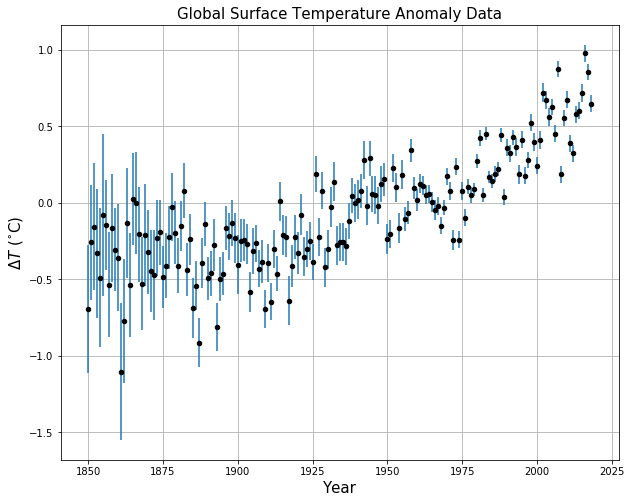

In [4]:
# We can plot temperature anomaly vs. time
plt.figure(figsize=(10,8))
plt.errorbar(year, temperature, tempUnc, linestyle='none')
plt.scatter(year, temperature, c='k', zorder=5, s=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('$\Delta T$ ($^{\circ}$C)', fontsize=15)
plt.title('Global Surface Temperature Anomaly Data', fontsize=15);
plt.grid()

As a starting point for doing Bayesian inference, parameter estimation, and eventually model comparison, we can consider a simple climate model that computes heating via the greenhouse gas effect.  This requires some timeseries data for the atmospheric emissions of GHG.  To compute temperature anomaly due to GHG, we employ the python package <code>pySCM</code>, or "Simple Climate Model."  The GHG considered in this model are carbon dioxide (CO$_2$), methane (CH$_4$), nitrous oxide (N$_{2}$O) and sulfate (SOx).  The SCM package comes with emissions curves for the various gasses. For our purposes, we will generalize the model by adding normalization factors $\alpha_{CO_2}, \alpha_{CH_4}, \alpha_{N_2O}$, and $\alpha_{SOx}$ that scale these curves. We also introduce a parameter $T_\text{shift}$ to exhange between temperature change (the output of the SMC package) and temperature anamoly. In sum, our generalized simple climate model has 5 parameters: 1 overall constant temperature shift and 4 normalizations to the GHG atmospheric emissions.

We will make some initial guess for the normalizations as 1, assuming that the emissions data produce a temperature anomaly curve that is similar to the actual data.  Based on the plot of temperature anomaly above, we will guess the shift as -0.4.  We will use a sampling method (affine-invariant ensemble average) to sample the posterior distribution.  We will assume a uniform prior on our shift parameter, as well as the normalizations.

We take as our log-likelihood:
$$\log(P(D|\theta, M))=\sum_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma_{Di}^2}}
- \frac{1}{2} \sum_{i=1}^N\left(\frac{T_{\rm Di}-T_{\rm SCMi}}{\sigma_{Di}}\right)^2,$$

where subscripts $Di$ and $SCMi$ refer to the $i^\text{th}$ data point and Simple Climate Model prediction at the corresponding $i^\text{th}$ time, respectively; $N$ is the total number of data points in the time series.  With uniform priors, the log-posterior distribution is then

$$\log(P(\theta\,|\,D, M)) \propto \log(P(D\,|\,\theta, M)) + \log(P(\theta\,|\,M))$$

We'll compute this below and output some best fit values for normalizations, shift, and some error intervals:

In [5]:
# Create Modified Simple Climate Model instance
SCM = model.ModifiedSimpleClimateModel(5, year, temperature, tempUnc)

In [6]:
# Set priors on parameters
prior_type = ['uniform' for i in range(5) ]
prior_param1 = [-0.5, 0.7, 0.7, 0.7, 0.7]
prior_param2 = [0.5, 1.3, 1.3, 1.3, 1.3]
SCM.set_priors(prior_type, prior_param1, prior_param2)

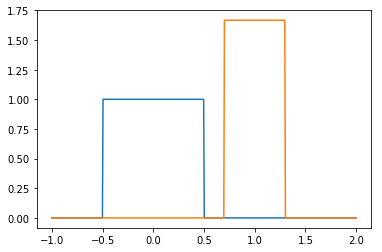

In [7]:
# Test that priors are working as expected
test_x = np.linspace(-1,2,500)
test_prior_1 = [ np.exp(SCM.priors[0](tx)) for tx in test_x ]
test_prior_2 = [ np.exp(SCM.priors[1](tx)) for tx in test_x ]
plt.plot(test_x, test_prior_1)
plt.plot(test_x, test_prior_2)

In [8]:
# Run MCMC on the model
paramGuess = [-0.4, 1., 1., 1., 1.]
%time SCMsample = SCM.run_MCMC(paramGuess, nwalkers=10, nsteps=300)

CPU times: user 11min 2s, sys: 4.73 s, total: 11min 6s
Wall time: 11min 7s


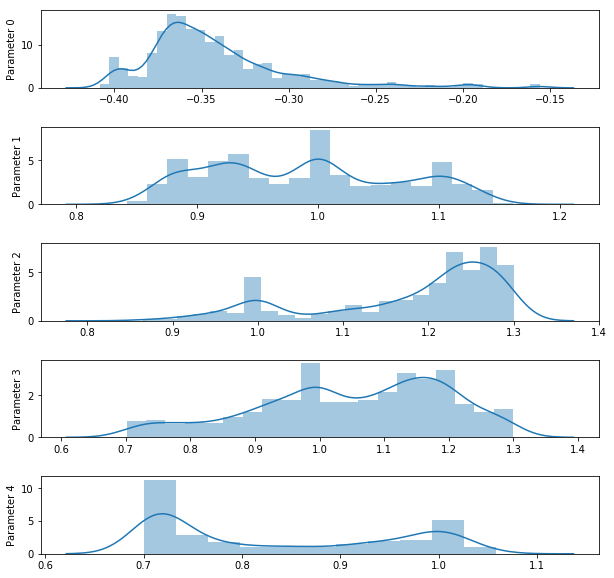

Param 0 = -0.351230 + 0.040552 - 0.022580
Param 1 = 0.991224 + 0.095848 - 0.090914
Param 2 = 1.222388 + 0.051539 - 0.216655
Param 3 = 1.067435 + 0.129174 - 0.168508
Param 4 = 0.789965 + 0.210013 - 0.078119
[-0.35122977558801005, 0.99122354147545533, 1.2223883253792907, 1.0674350860162514, 0.78996455712406921]


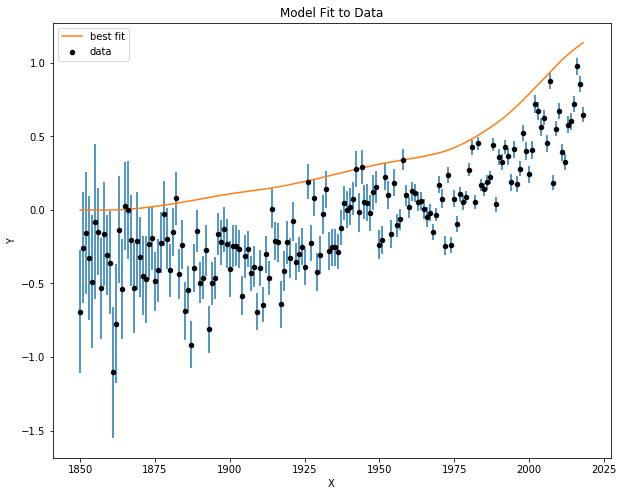

In [9]:
# Plot results from the sampling
SCM.show_results(burnin=100)

In [10]:
# Test Cloud Seeding Model
test_solar_data = np.sin(2*np.pi / 11 * year)
CSModel = model.BasicCloudSeedingModel(2, year, temperature, tempUnc, year, test_solar_data)

In [11]:
# Set priors on parameters
prior_type = ['uniform' for i in range(5) ]
prior_param1 = [-1, 0]
prior_param2 = [ 1, 5]
CSModel.set_priors(prior_type, prior_param1, prior_param2)

In [12]:
# Run MCMC on the cloud seeding model
paramGuess = [0, 0]
%time CSModelSample = CSModel.run_MCMC(paramGuess, nwalkers=10, nsteps=300)

(array([-0.00010996,  0.00010741]),)
(array([  2.08831328e-04,  -5.97183439e-05]),)
(array([ -2.06012354e-05,   1.19045241e-04]),)
(array([-0.00010898,  0.00014369]),)
(array([ -5.47208288e-05,  -9.10040254e-05]),)
(array([ -1.45523146e-04,   4.98768486e-05]),)
(array([ -2.04166923e-05,  -2.33823696e-04]),)
(array([ -5.72490370e-05,   8.85478999e-05]),)
(array([  5.61887834e-05,  -1.14574169e-05]),)
(array([  6.62079618e-05,   2.05649455e-05]),)
(array([ -9.86899097e-05,   1.01850118e-04]),)
(array([  2.51123473e-04,  -8.32845227e-05]),)
(array([ -2.62360762e-05,   1.15925269e-04]),)
(array([-0.00026318,  0.00028853]),)
(array([ -3.95816637e-05,  -1.54033467e-04]),)
(array([ -9.09472118e-05,   3.29975358e-05]),)
(array([ -1.98812059e-05,  -2.34975928e-04]),)
(array([ -5.67487715e-05,   5.30193211e-05]),)
(array([ -2.77598917e-05,   1.50845991e-05]),)
(array([  3.89006709e-05,  -4.62877658e-06]),)
(array([ -8.44571507e-05,   4.08130910e-05]),)
(array([ 0.00034794, -0.00010274]),)
(array

/home/brendon/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/brendon/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([ 0.0012214 ,  0.00084069]),)
(array([ 0.00046985,  0.00186493]),)
(array([ 0.0008545 ,  0.00130383]),)
(array([ 0.00191682,  0.00064611]),)
(array([ 0.01058404,  0.00012672]),)
(array([ 0.00087726,  0.00305649]),)
(array([ 0.00075344,  0.00155713]),)
(array([ 0.00634091,  0.00041127]),)
(array([-0.00448752,  0.00079359]),)
(array([ 0.00662905,  0.00024683]),)
(array([ 0.00128393,  0.0007303 ]),)
(array([ 0.00067105,  0.00245339]),)
(array([-0.00317688,  0.00179156]),)
(array([ 0.00320154, -0.00043604]),)
(array([ 0.00900407,  0.00039825]),)
(array([ 0.00341742,  0.00181566]),)
(array([ 0.00074967,  0.00156122]),)
(array([ 0.00407387,  0.00097259]),)
(array([ 0.00296293,  0.00049563]),)
(array([ 0.00655305,  0.0002902 ]),)
(array([ 0.00104446,  0.00074541]),)
(array([-0.00073834,  0.00188512]),)
(array([ 0.0009661 ,  0.00123474]),)
(array([ 0.00264713,  0.00019395]),)
(array([  1.13770610e-02,   9.45590816e-05]),)
(array([ 0.00359101,  0.00231982]),)
(array([ 0.00083897,  0.0013

(array([ 0.02270812,  0.00095943]),)
(array([ 0.04331679,  0.00120527]),)
(array([ 0.08279127,  0.0068842 ]),)
(array([-0.00089353,  0.00015484]),)
(array([-0.00478514,  0.0002543 ]),)
(array([ 0.03806857,  0.00114494]),)
(array([ 0.018221  ,  0.00363983]),)
(array([ 0.03595125,  0.00189414]),)
(array([ 0.02340345,  0.00364537]),)
(array([ 0.02096202,  0.00219694]),)
(array([ 0.02443511, -0.00160666]),)
(array([ 0.04414341,  0.00112796]),)
(array([ 0.06836093,  0.00590196]),)
(array([ 0.02482184,  0.00096393]),)
(array([ 0.01935805,  0.00071195]),)
(array([ 0.03392694,  0.00115652]),)
(array([ 0.02069937,  0.00355682]),)
(array([ 0.04259908,  0.00175985]),)
(array([ 0.02785056,  0.00323086]),)
(array([ 0.02108236,  0.00218954]),)
(array([ 0.02535553,  0.001155  ]),)
(array([ 0.04237652,  0.0011329 ]),)
(array([ 0.10902436,  0.00943676]),)
(array([ 0.02608019,  0.00190578]),)
(array([ 0.01910052,  0.00049127]),)
(array([ 0.03894405,  0.00108938]),)
(array([ 0.02248557,  0.00263543]),)
(

(array([ 0.08087601,  0.03984468]),)
(array([ 0.08086489,  0.00079912]),)
(array([ 0.09822791,  0.07414257]),)
(array([ 0.08082604,  0.06394224]),)
(array([ 0.08032884, -0.03355196]),)
(array([ 0.08099817,  0.09259353]),)
(array([ 0.07370258,  0.03661989]),)
(array([ 0.08412534,  0.05931421]),)
(array([ 0.08673952,  0.04772539]),)
(array([ 0.0813458, -0.0149685]),)
(array([ 0.08086207,  0.03818258]),)
(array([ 0.08092513,  0.00527152]),)
(array([ 0.10200074,  0.08281807]),)
(array([ 0.08112176,  0.05922345]),)
(array([ 0.08166912,  0.01356265]),)
(array([ 0.0810286 ,  0.08317564]),)
(array([ 0.08383623,  0.05316359]),)
(array([ 0.08924423,  0.06604489]),)
(array([ 0.08428893,  0.03121411]),)
(array([ 0.08097495,  0.03325792]),)
(array([ 0.08078858,  0.01832678]),)
(array([ 0.07740772, -0.02042415]),)
(array([ 0.0965482 ,  0.06693192]),)
(array([ 0.07986661,  0.07032351]),)
(array([ 0.0795306 , -0.00084599]),)
(array([ 0.08101025,  0.06609715]),)
(array([ 0.08309197,  0.06111937]),)
(ar

(array([ 0.08801971,  0.10926465]),)
(array([ 0.07930335,  0.01041832]),)
(array([ 0.08584647,  0.04721074]),)
(array([ 0.10260261, -0.01404104]),)
(array([ 0.06982848,  0.03465651]),)
(array([ 0.0731303 ,  0.09843425]),)
(array([ 0.07520752,  0.06747715]),)
(array([ 0.10709118,  0.21686262]),)
(array([ 0.07586396,  0.20199242]),)
(array([ 0.09856337,  0.11038035]),)
(array([ 0.09555871,  0.19475938]),)
(array([ 0.08059866,  0.02510757]),)
(array([ 0.08402721, -0.00473586]),)
(array([ 0.10116974, -0.00389537]),)
(array([ 0.06819634,  0.02755961]),)
(array([ 0.0627922 ,  0.09091442]),)
(array([ 0.07099794,  0.10056068]),)
(array([ 0.09716317,  0.14259784]),)
(array([ 0.07667522,  0.17168471]),)
(array([ 0.08481511,  0.11190655]),)
(array([ 0.08963946,  0.15551462]),)
(array([ 0.07891499, -0.00955228]),)
(array([ 0.09450711,  0.01609356]),)
(array([ 0.09257344,  0.05697224]),)
(array([ 0.07175207,  0.04877727]),)
(array([ 0.0745641 ,  0.12806162]),)
(array([ 0.07203996,  0.10859637]),)
(

(array([ 0.1029982 , -0.01991108]),)
(array([ 0.08329896,  0.06875716]),)
(array([ 0.08431462,  0.16908772]),)
(array([ 0.08458696,  0.05674225]),)
(array([ 0.09175445,  0.14951621]),)
(array([ 0.0863386 ,  0.25773449]),)
(array([ 0.08875736,  0.19064499]),)
(array([ 0.07893143,  0.21487848]),)
(array([ 0.07379202,  0.04929019]),)
(array([ 0.09174769,  0.15468493]),)
(array([ 0.10949956,  0.09892808]),)
(array([ 0.08008848,  0.07285429]),)
(array([ 0.08515564,  0.16687529]),)
(array([ 0.08109797,  0.09177745]),)
(array([ 0.09179391,  0.15002641]),)
(array([ 0.08882241,  0.21041497]),)
(array([ 0.08991569,  0.16980009]),)
(array([ 0.06742794,  0.26890639]),)
(array([ 0.07898053,  0.10491069]),)
(array([ 0.09260037,  0.14764976]),)
(array([ 0.09434373,  0.09011482]),)
(array([ 0.07989188, -0.01282902]),)
(array([ 0.08349201,  0.14712116]),)
(array([ 0.08026221,  0.05113755]),)
(array([ 0.08768635,  0.13556376]),)
(array([ 0.08640425,  0.25058898]),)
(array([ 0.08886187,  0.15117195]),)
(

(array([ 0.0830091 ,  0.07552257]),)
(array([ 0.08523185,  0.03501599]),)
(array([ 0.1022111 ,  0.66183441]),)
(array([ 0.08696951, -0.0303278 ]),)
(array([ 0.08060517,  0.19674252]),)
(array([ 0.0635832 ,  0.23002188]),)
(array([ 0.08551888,  0.20648897]),)
(array([ 0.0856617 ,  0.03512024]),)
(array([ 0.07610986, -0.06509266]),)
(array([ 0.09518829, -0.06998335]),)
(array([ 0.08029726,  0.11416499]),)
(array([ 0.08525158,  0.03502077]),)
(array([ 0.09082915,  0.47097869]),)
(array([ 0.0870064 ,  0.02741343]),)
(array([ 0.07797875,  0.24477975]),)
(array([ 0.06988118,  0.1197173 ]),)
(array([ 0.0856929 ,  0.20683414]),)
(array([ 0.08905822, -0.06410097]),)
(array([ 0.07538682, -0.051012  ]),)
(array([ 0.09463541, -0.01804727]),)
(array([ 0.08134637,  0.14945498]),)
(array([ 0.08501973,  0.03496454]),)
(array([ 0.08914313,  0.21397347]),)
(array([ 0.08889305,  0.01573193]),)
(array([ 0.0804413,  0.1997396]),)
(array([ 0.06069403,  0.07476104]),)
(array([ 0.08597371,  0.27852838]),)
(ar

(array([ 0.08163225,  0.09991588]),)
(array([ 0.09019624, -0.00872621]),)
(array([ 0.0717698 ,  0.12303484]),)
(array([ 0.08831273,  0.02012087]),)
(array([ 0.08598202,  0.09931128]),)
(array([ 0.09268554,  0.24640089]),)
(array([ 0.08755446,  0.35264097]),)
(array([ 0.07942578,  0.23819203]),)
(array([ 0.09124379,  0.06185255]),)
(array([ 0.08500483, -0.03308818]),)
(array([ 0.08147857,  0.10175157]),)
(array([ 0.09148734, -0.04558061]),)
(array([ 0.06584788,  0.03396048]),)
(array([ 0.08782099,  0.02620244]),)
(array([ 0.08913531,  0.14597438]),)
(array([ 0.09462748,  0.28281432]),)
(array([ 0.09358824,  0.64068023]),)
(array([ 0.06558599,  0.19756744]),)
(array([ 0.08928924, -0.06578294]),)
(array([ 0.0811368 ,  0.04627668]),)
(array([ 0.08283132,  0.08563795]),)
(array([ 0.08697167,  0.00757165]),)
(array([ 0.06025468,  0.02781752]),)
(array([ 0.08821547,  0.03485587]),)
(array([ 0.08920836,  0.14705549]),)
(array([ 0.09600907,  0.3730345 ]),)
(array([ 0.09396495,  0.65866351]),)
(

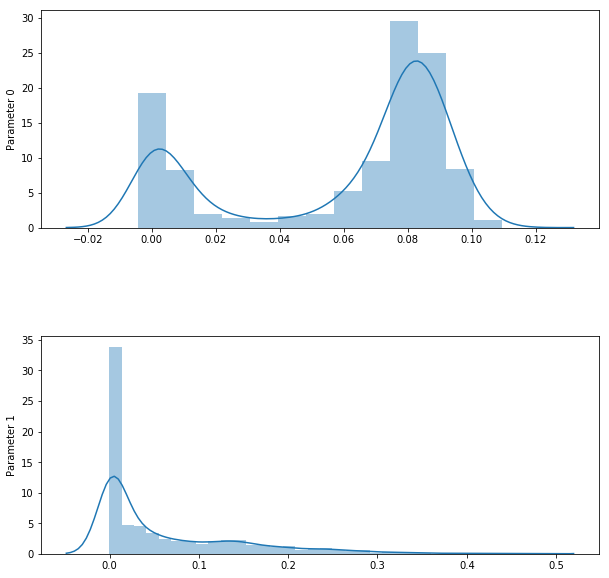

Param 0 = 0.077834 + 0.010688 - 0.074270
Param 1 = 0.019225 + 0.128096 - 0.018532
[0.077834143531953295, 0.019224553730927824]


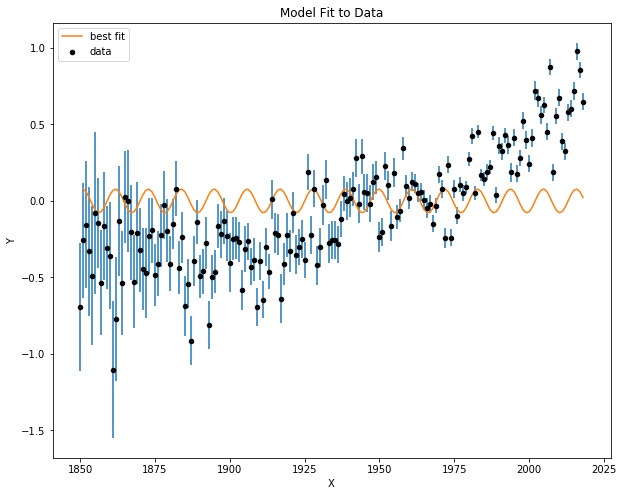

In [13]:
# Plot results from the sampling
CSModel.show_results(burnin=100)

This was a very coarse sampling of the distribution, because the model takes ~0.35 seconds for each run, so we might consider some parallel processing in the future using the Odyssey cluster.  We should also think more carefully about how we define our priors.